# Recurrent Neurons and Layer

### Memory Cell

### Input and Output Sequences

# Training RNNs

# Forecasting a Time Series

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

In [107]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps) #.shape = (n_step, )
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1 .shape = (batch_size, n_steps)
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [108]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [109]:
series.shape

(10000, 51, 1)

In [110]:
X_train.shape, X_train[1].shape, y_train.shape

((7000, 50, 1), (50, 1), (7000, 1))

In [111]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, '.-')
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction" )
        # markersize là kích thước kiểu đanh dấu
    plt.grid(True)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.hlines(0, 0, 100, linewidth=1) #y, xmin, xnmax
    plt.axis([0, n_steps + 1, -1, 1])
    if legend:
        plt.legend()

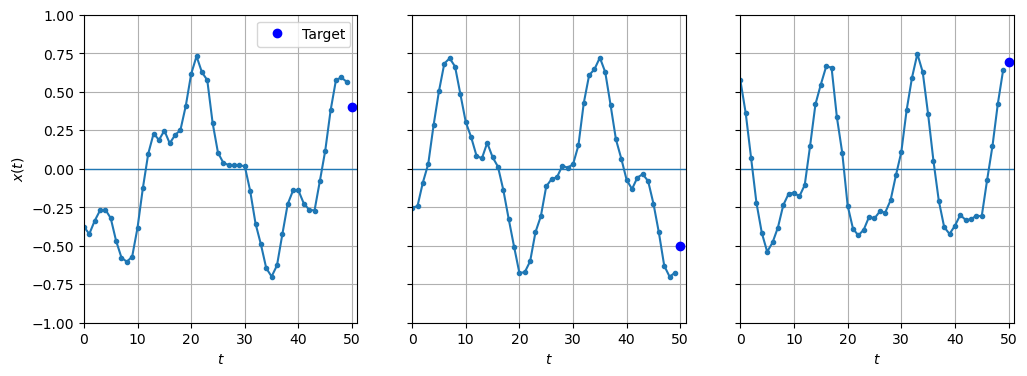

In [112]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col]) # Chọn trục col là trục vẽ hiện thời
    plot_series(X_valid[col, :, 0], y_valid[col, 0],                 
                y_label=("$x(t)$" if col==0 else None),
                legend =(col == 0))
plt.show()

### Baseline Metrics

In [113]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

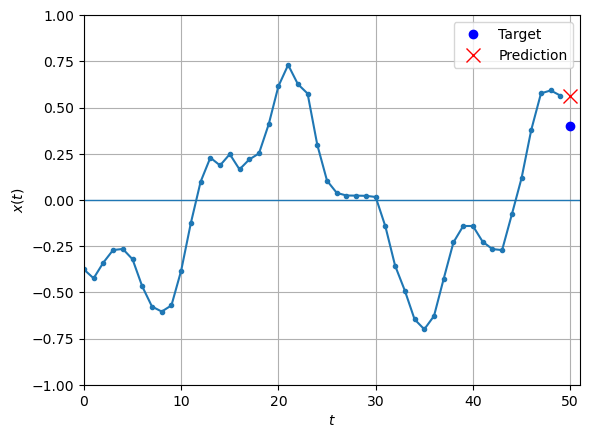

In [114]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [115]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1162 - val_loss: 0.0362
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0130
Epoch 3/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0105 - val_loss: 0.0088
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0077
Epoch 5/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0073 - val_loss: 0.0070
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 7/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0059
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0049

In [116]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0037


0.0037201978266239166

In [117]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

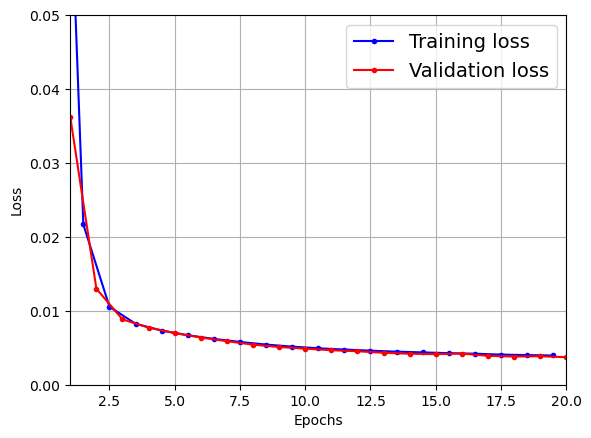

In [118]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])

63/63 [==============================] - 0s 1ms/step


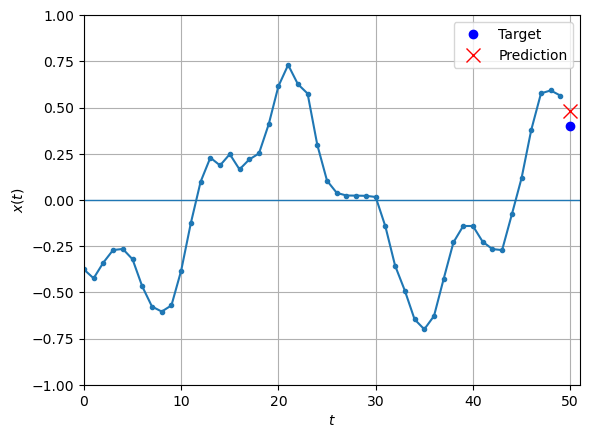

In [119]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

### Implementing a Simple RNN

In [120]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 12ms/step - loss: 0.1274 - val_loss: 0.0328
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0279 - val_loss: 0.0240
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0214 - val_loss: 0.0190
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0176 - val_loss: 0.0159
Epoch 5/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0152 - val_loss: 0.0139
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0136 - val_loss: 0.0126
Epoch 7/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0126 - val_loss: 0.0118
Epoch 8/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0120 - val_loss: 0.0113
Epoch 9/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0116 - val_loss: 0.0110
Epoch 10/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0115 - val_loss: 

In [121]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_14 (SimpleRNN)   (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [122]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0109


0.010885053314268589

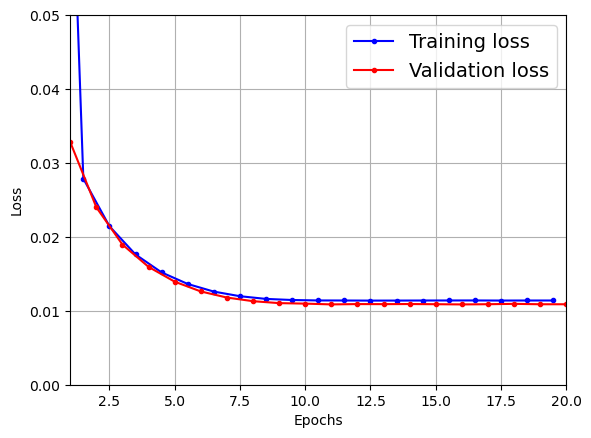

In [123]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 4ms/step


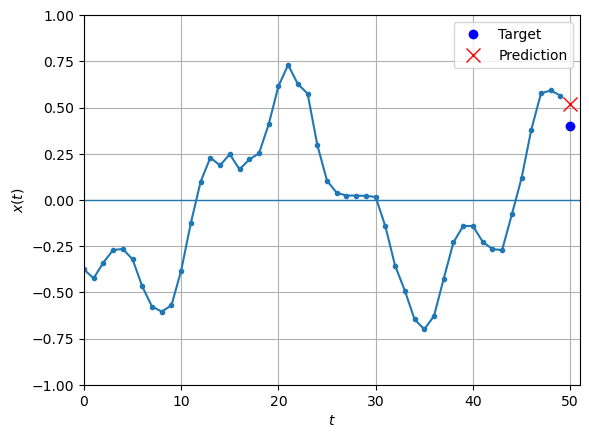

In [124]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

In [125]:
y_pred.shape

(2000, 1)

### Deep RNNs

In [126]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="Adam")
history = model.fit(X_train, y_train, epochs=20, 
                   validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 10s 27ms/step - loss: 0.0415 - val_loss: 0.0086
Epoch 2/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0069 - val_loss: 0.0053
Epoch 3/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 4/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 5/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 6/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 7/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 9/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 10/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0035 - val_l

In [127]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_15 (SimpleRNN)   (None, None, 20)          440       
                                                                 
 simple_rnn_16 (SimpleRNN)   (None, None, 20)          820       
                                                                 
 simple_rnn_17 (SimpleRNN)   (None, 1)                 22        
                                                                 
Total params: 1282 (5.01 KB)
Trainable params: 1282 (5.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [128]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 7ms/step - loss: 0.0027


0.002736308379098773

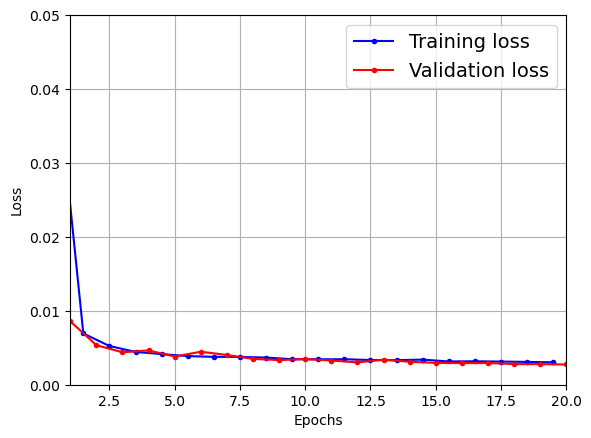

In [129]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

63/63 [==============================] - 1s 8ms/step


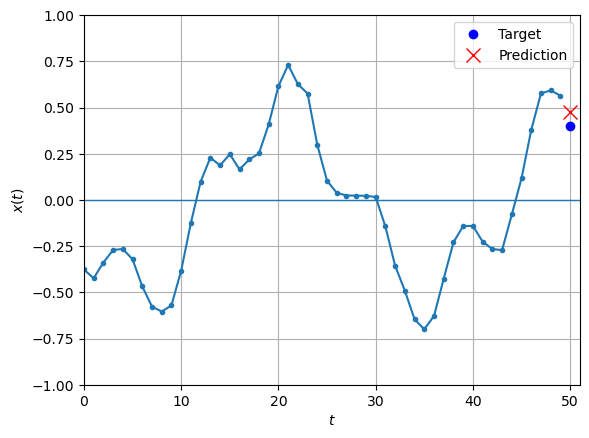

In [130]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

In [131]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), 
    keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                   validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 21ms/step - loss: 0.0150 - val_loss: 0.0043
Epoch 2/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 3/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 4/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 5/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 7/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 10/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0031 - val_lo

In [132]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 7ms/step - loss: 0.0027


0.0026525123976171017

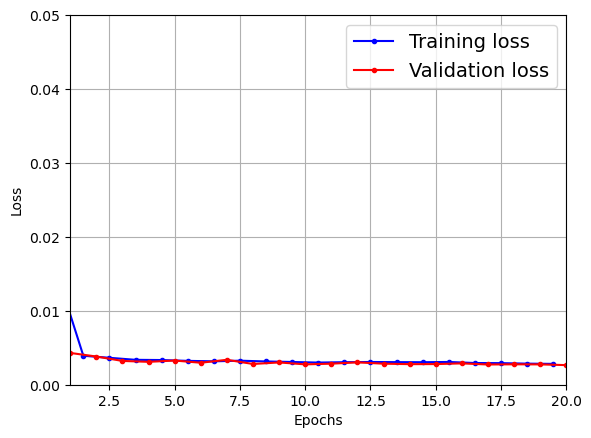

In [133]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

63/63 [==============================] - 1s 6ms/step


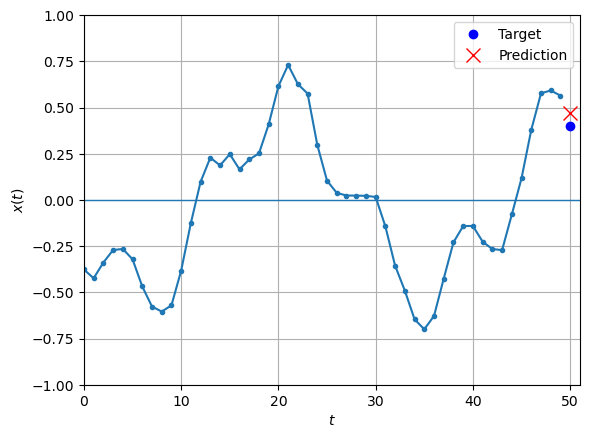

In [134]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

In [135]:
model_test = keras.models.Sequential([
    keras.layers.SimpleRNN(20, input_shape=[None, 1], return_sequences=True),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1, return_sequences=True) # Để return_sequences ở cuối hàng thì sẽ predict / mỗi bước thời gian
])

model_test.compile(loss="mse", optimizer='adam')
model_test.fit(X_train, y_train, epochs=20, 
          validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 10s 28ms/step - loss: 0.1470 - val_loss: 0.1493
Epoch 2/20
219/219 [==============================] - 6s 25ms/step - loss: 0.1403 - val_loss: 0.1284
Epoch 3/20
219/219 [==============================] - 6s 26ms/step - loss: 0.1163 - val_loss: 0.1227
Epoch 4/20
219/219 [==============================] - 6s 27ms/step - loss: 0.1030 - val_loss: 0.1028
Epoch 5/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0961 - val_loss: 0.0999
Epoch 6/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0929 - val_loss: 0.0906
Epoch 7/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0905 - val_loss: 0.0900
Epoch 8/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0893 - val_loss: 0.0905
Epoch 9/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0879 - val_loss: 0.0910
Epoch 10/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0866 - val_l

In [136]:
model_test.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_20 (SimpleRNN)   (None, None, 20)          440       
                                                                 
 simple_rnn_21 (SimpleRNN)   (None, None, 20)          820       
                                                                 
 simple_rnn_22 (SimpleRNN)   (None, None, 1)           22        
                                                                 
Total params: 1282 (5.01 KB)
Trainable params: 1282 (5.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [137]:
model_test.predict(X_valid[:1, :])

1/1 [==============================] - 0s 408ms/step


array([[[ 0.00329406],
        [-0.0109588 ],
        [-0.00400711],
        [-0.03042981],
        [-0.03175714],
        [-0.01252098],
        [ 0.02674614],
        [ 0.08073545],
        [ 0.09424109],
        [ 0.10850208],
        [ 0.1438122 ],
        [ 0.14408265],
        [ 0.18091224],
        [ 0.2123838 ],
        [ 0.2898088 ],
        [ 0.36058757],
        [ 0.3278116 ],
        [ 0.3499916 ],
        [ 0.4269834 ],
        [ 0.41816127],
        [ 0.41105434],
        [ 0.40917236],
        [ 0.34472167],
        [ 0.31869316],
        [ 0.31014043],
        [ 0.35107797],
        [ 0.34723118],
        [ 0.37235853],
        [ 0.3673523 ],
        [ 0.33850282],
        [ 0.3848023 ],
        [ 0.45303938],
        [ 0.4572096 ],
        [ 0.38567922],
        [ 0.39348555],
        [ 0.37940907],
        [ 0.4121576 ],
        [ 0.45179954],
        [ 0.5015537 ],
        [ 0.4654251 ],
        [ 0.43789294],
        [ 0.34902588],
        [ 0.2874582 ],
        [ 0

### Forecasting Several Time Steps Ahead

In [138]:
np.random.seed(43)

series = generate_time_series(1, n_steps + 10)
X_new, y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    # Mở rộng chiều y_pred_one 1 chiều (1) thành 3 chiều (1, 1, 1)
    X = np.concatenate([X, y_pred_one], axis=1)
    # Nối y vừa mới predict vào X ban đầu lại
y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 24ms/step


In [139]:
X.shape

(1, 60, 1)

In [140]:
y_pred.shape

(1, 10, 1)

In [141]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], 'bo-', label='Actual')
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], 'rx-', label='Forecas', markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


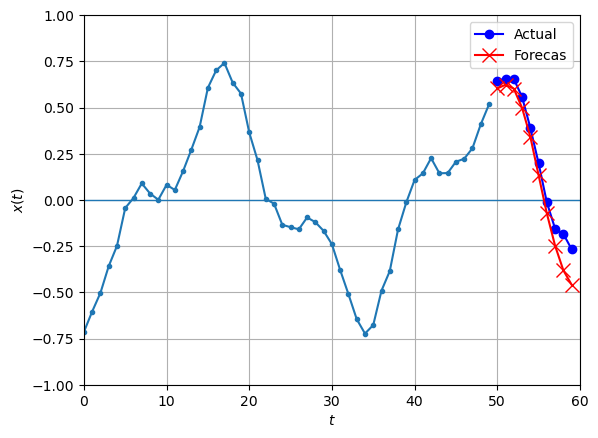

In [142]:
plot_multiple_forecasts(X_new, y_new, y_pred)

In [143]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, y_train = series[:7000, : n_steps], series[:7000, -10:, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [144]:
X_train.shape

(7000, 50, 1)

In [145]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 0s 6ms/step


In [146]:
y_pred.shape

(2000, 10)

In [147]:
np.mean(keras.metrics.mean_squared_error(y_valid, y_pred))

0.021674436

In [148]:
y_navie_pred = np.tile(X_valid[:, -1], 10) #Lấy giá trị cuối cùng và lặp lại 10 lần 
np.mean(keras.metrics.mean_squared_error(y_valid, y_navie_pred))

0.25697407

In [149]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1378 - val_loss: 0.0656
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0455
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0377
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0333
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0303
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0291 - val_loss: 0.0282
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0272 - val_loss: 0.0263
Epoch 8/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0257 - val_loss: 0.0249
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0246 - val_loss: 0.0239
Epoch 10/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0236 - val_loss: 0.0230

In [152]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, 
                   validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 23ms/step - loss: 0.0633 - val_loss: 0.0337
Epoch 2/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0256 - val_loss: 0.0172
Epoch 3/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0162 - val_loss: 0.0142
Epoch 4/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0140 - val_loss: 0.0131
Epoch 5/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0128 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0117 - val_loss: 0.0105
Epoch 7/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0110 - val_loss: 0.0106
Epoch 8/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0105 - val_loss: 0.0094
Epoch 9/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0102 - val_loss: 0.0107
Epoch 10/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0098 - val_lo

In [153]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 0s 375ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


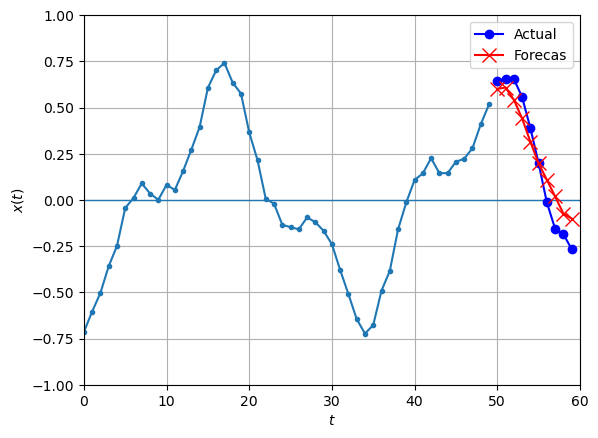

In [154]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)

In [155]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10_000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:,:n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10+1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [156]:
Y[..., 0].shape

(10000, 50)

In [157]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [158]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [159]:
model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, 
                   validation_data=(X_valid, Y_valid))

Epoch 1/20

219/219 [==============================] - 8s 22ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0390 - val_last_time_step_mse: 0.0230
Epoch 2/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0379 - last_time_step_mse: 0.0251 - val_loss: 0.0342 - val_last_time_step_mse: 0.0223
Epoch 3/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0311 - last_time_step_mse: 0.0183 - val_loss: 0.0285 - val_last_time_step_mse: 0.0150
Epoch 4/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0285 - last_time_step_mse: 0.0165 - val_loss: 0.0262 - val_last_time_step_mse: 0.0147
Epoch 5/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0269 - last_time_step_mse: 0.0150 - val_loss: 0.0275 - val_last_time_step_mse: 0.0166
Epoch 6/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0259 - last_time_step_mse: 0.0141 - val_loss: 0.0258 - val_last_time_step_mse: 0.0139
Epoch 7/20
219/219 [=

In [160]:
np.random.seed(43)

series = generate_time_series(1, 50+10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]


1/1 [==============================] - 0s 289ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


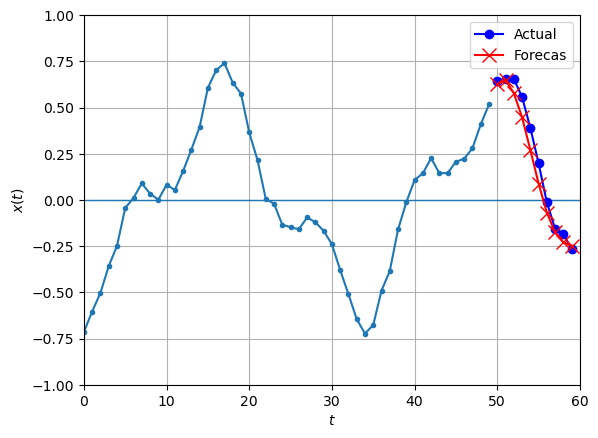

In [161]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)

# Handling Long Sequences

### Fighting the Unstable Gradients Problem

In [78]:
# Deep RNN with Batch Norm

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [79]:
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
model.fit(X_train, Y_train, epochs=20, validation_batch_size=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 16ms/step - loss: 0.1890 - last_time_step_mse: 0.1699
Epoch 2/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0523 - last_time_step_mse: 0.0409
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0448 - last_time_step_mse: 0.0337
Epoch 4/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0407 - last_time_step_mse: 0.0298
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0379 - last_time_step_mse: 0.0270
Epoch 6/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0360 - last_time_step_mse: 0.0245
Epoch 7/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0345 - last_time_step_mse: 0.0229
Epoch 8/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0328 - last_time_step_mse: 0.0209
Epoch 9/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0315 - last_time_step_mse: 0.0191
E

In [81]:
from tensorflow.keras.layers import LayerNormalization

In [82]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [83]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))


Epoch 1/20
219/219 [==============================] - 17s 56ms/step - loss: 0.1463 - last_time_step_mse: 0.1311 - val_loss: 0.0701 - val_last_time_step_mse: 0.0567
Epoch 2/20
219/219 [==============================] - 13s 58ms/step - loss: 0.0633 - last_time_step_mse: 0.0515 - val_loss: 0.0580 - val_last_time_step_mse: 0.0447
Epoch 3/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0543 - last_time_step_mse: 0.0408 - val_loss: 0.0517 - val_last_time_step_mse: 0.0370
Epoch 4/20
219/219 [==============================] - 12s 55ms/step - loss: 0.0498 - last_time_step_mse: 0.0357 - val_loss: 0.0476 - val_last_time_step_mse: 0.0335
Epoch 5/20
219/219 [==============================] - 12s 56ms/step - loss: 0.0462 - last_time_step_mse: 0.0316 - val_loss: 0.0443 - val_last_time_step_mse: 0.0292
Epoch 6/20
219/219 [==============================] - 12s 54ms/step - loss: 0.0425 - last_time_step_mse: 0.0272 - val_loss: 0.0402 - val_last_time_step_mse: 0.0252
Epoch 7/20
219/

In [84]:
## Creating a Custom RNN Class

In [85]:
### LSTMs

In [91]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [92]:
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, 
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 12s 33ms/step - loss: 0.0752 - last_time_step_mse: 0.0605 - val_loss: 0.0528 - val_last_time_step_mse: 0.0326
Epoch 2/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0445 - last_time_step_mse: 0.0233 - val_loss: 0.0394 - val_last_time_step_mse: 0.0177
Epoch 3/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0363 - last_time_step_mse: 0.0158 - val_loss: 0.0345 - val_last_time_step_mse: 0.0143
Epoch 4/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0329 - last_time_step_mse: 0.0139 - val_loss: 0.0314 - val_last_time_step_mse: 0.0128
Epoch 5/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0307 - last_time_step_mse: 0.0129 - val_loss: 0.0298 - val_last_time_step_mse: 0.0123
Epoch 6/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0294 - last_time_step_mse: 0.0123 - val_loss: 0.0287 - val_last_time_step_mse: 0.0117
Epoch 7/20
219/219 [=

In [93]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 9ms/step - loss: 0.0228 - last_time_step_mse: 0.0082


[0.022754492238163948, 0.008178044110536575]

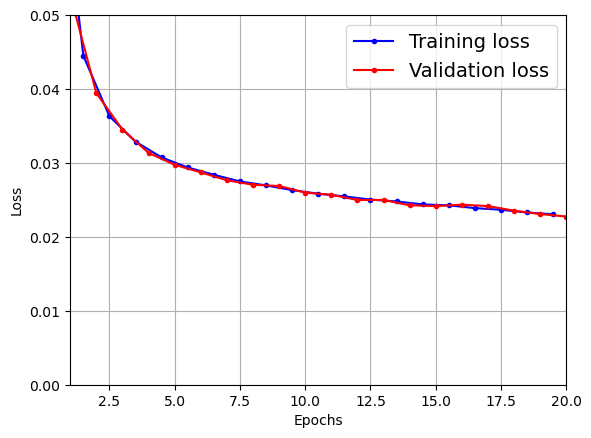

In [94]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [96]:
np.random.seed(43)

series = generate_time_series(1, 50+10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 47ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


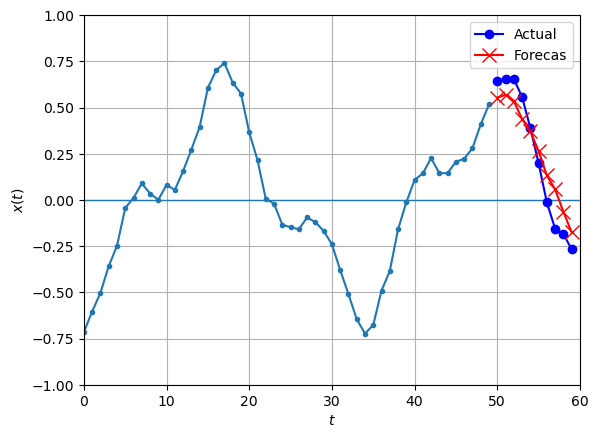

In [97]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)

In [98]:
### Peephole connections

In [99]:
### GRU cells